## Загрузка данных

Это будет датасет про диабет, доступный в самой библиотеке sklearn

In [1]:
import pandas as pd

In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [4]:
pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


## Важность признаков по коэффициентам

Будем использовать `sklearn.linear_model.RidgeCV`. Признаки с самыми высокими весовыми коэффициентами самые важные. Поскольку все признаки уже масштабированы, нам не надо это делать.

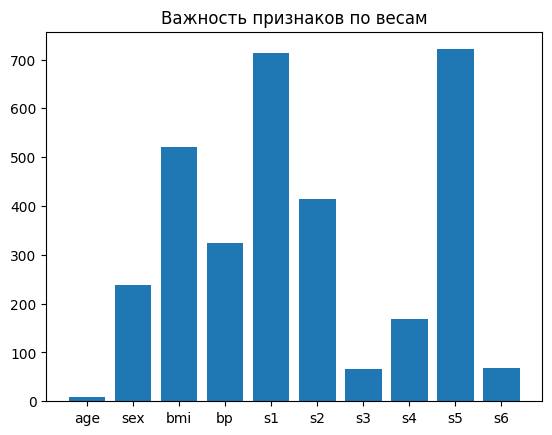

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Важность признаков по весам")
plt.show()

In [7]:
np.sort(importance)

array([  9.54916175,  65.81132269,  68.12336029, 167.51300694,
       239.08695779, 323.82274522, 413.37912498, 520.3693746 ,
       712.32215918, 720.9399241 ])

## Отберем признаки по весам

Мы хотим отобрать 2 самых важных с точки зрения модели признака. Класс `~sklearn.feature_selection.SelectFromModel` как раз для этого. У класса есть гиперпараметр `threshold`, который позволяет устанавливать порог отсечения признаков.

In [8]:
from time import time

from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-4] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Признаки отобранные SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Выполнено за {toc - tic:.3f}с")

Признаки отобранные SelectFromModel: ['bmi' 's1' 's5']
Выполнено за 0.004с


In [9]:
sfm.get_support()

array([False, False,  True, False,  True, False, False, False,  True,
       False])

## Еще один способ отбора признаков - Sequential Feature Selection

Класс `~sklearn.feature_selection.SequentialFeatureSelector` представляет собой "жадный" алгоритм отбора признаков, в процессе работы которого мы подбираем на каждой итерации самый лучший признак на кросс-валидации. Мы начниаем с нулевым набором признаков и добавляем на каждой итерации по одному, получившему самую большую оценку. Процедуру мы продолжаем то тех пор, пока, или не закончатся признаки, или мы не наберем пороговое число признаков.
Процедура работает в прямом и обратном направлении.



In [10]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=3, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=3, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Признаки, отобранные прямым отбором: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Признаки отобранные обратным отбором: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Выполнено за {toc_bwd - tic_bwd:.3f}с")

Признаки, отобранные прямым отбором: ['bmi' 'bp' 's5']
Done in 0.462s
Признаки отобранные обратным отбором: ['bmi' 'bp' 's5']
Выполнено за 0.811с


## Использование различных значений negative tolerance

Мы може использовать класс `~sklearn.feature_selection.SequentialFeatureSelector` создания более компактного набора признаков при использовании некоторого сочетания гиперпараметров модели, так как: `direction="backward"` и `tol` с отрицательными значениями.


In [11]:
import numpy as np

from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()
X, y = breast_cancer_data.data, breast_cancer_data.target
feature_names = np.array(breast_cancer_data.feature_names)
print(breast_cancer_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Будем использовать `~sklearn.linear_model.LogisticRegression` совместно с `~sklearn.feature_selection.SequentialFeatureSelector` для отбора признаков.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

for tol in [-1e-2, -1e-3, -1e-4]:
    start = time()
    feature_selector = SequentialFeatureSelector(
        LogisticRegression(),
        n_features_to_select="auto",
        direction="backward",
        scoring="roc_auc",
        tol=tol,
        n_jobs=2,
    )
    model = make_pipeline(StandardScaler(), feature_selector, LogisticRegression())
    model.fit(X, y)
    end = time()
    print(f"\ntol: {tol}")
    print(f"Отобранные признаки: {feature_names[model[1].get_support()]}")
    print(f"ROC AUC: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.3f}")
    print(f"Выполнено за {end - start:.3f}с")


tol: -0.01
Отобранные признаки: ['worst perimeter']
ROC AUC: 0.975
Выполнено за 23.843с

tol: -0.001
Отобранные признаки: ['radius error' 'fractal dimension error' 'worst texture'
 'worst perimeter' 'worst concave points']
ROC AUC: 0.997
Выполнено за 20.331с

tol: -0.0001
Отобранные признаки: ['mean compactness' 'mean concavity' 'mean concave points' 'radius error'
 'area error' 'concave points error' 'symmetry error'
 'fractal dimension error' 'worst texture' 'worst perimeter' 'worst area'
 'worst concave points' 'worst symmetry']
ROC AUC: 0.998
Выполнено за 18.089с


Мы видим, что набор признаков становиться разнообразнее по мере приближения отрицательного значения `tol` к 0.